In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import matplotlib.pyplot as plt

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print(tf.test.is_gpu_available())

target_size = (120, 160)
batch_size = 50

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        'training',  
        target_size=(target_size[0], target_size[1]),
        batch_size=batch_size,
        class_mode='categorical')

valid_generator = train_datagen.flow_from_directory(
        'validation', 
        target_size=target_size, 
        batch_size=batch_size,
        class_mode='categorical')

True
Found 15050 images belonging to 10 classes.
Found 2200 images belonging to 10 classes.


In [2]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D, LSTM, SpatialDropout1D, TimeDistributed, MaxPool2D, Lambda, InputLayer, Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential

class CustomModel:
    input = None
    model = None
    def __init__(self, input_shape):
        self.input = input_shape
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(self.input[0], self.input[1],3), batch_size = batch_size))
        self.model.add(InceptionV3(include_top=False, input_shape=(self.input[0], self.input[1],3), weights = 'imagenet'))

    def constructModel_LSTM(self):
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(self.input[1], self.input[0],3), batch_size = batch_size))
        self.model.add(Lambda(lambda x : tf.reshape(x, (tf.shape(x)[0],1,self.input[1], self.input[0],3))))
        self.model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
        self.model.add(TimeDistributed(MaxPool2D(2,2)))
        self.model.add(TimeDistributed(Conv2D(48, (5,5), activation='relu')))
        self.model.add(TimeDistributed(MaxPool2D(2,2)))
        self.model.add(TimeDistributed(Conv2D(64, (5,5), activation='relu')))
        self.model.add(TimeDistributed(MaxPool2D(2,2)))
        self.model.add(TimeDistributed(Flatten()))
        self.model.add(LSTM(512))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(10, activation='softmax'))

    def constructModel_LSTM_Transfer_Learning(self):
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(self.input[0], self.input[1],3), batch_size = batch_size))
        self.model.add(Lambda(lambda x : tf.reshape(x, (tf.shape(x)[0],1,self.input[0], self.input[1],3))))
        self.model.add(TimeDistributed(InceptionV3(include_top=False, weights = 'imagenet')))
        self.model.add(TimeDistributed(Flatten()))
        self.model.add(Bidirectional(LSTM(512, return_sequences=True, dropout = 0.3)))
        self.model.add(Bidirectional(LSTM(128)))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(10, activation='softmax'))


    def constructModel_2DCNN(self):
        self.model = Sequential()
        self.model.add(InceptionV3(input_shape=(self.input[1], self.input[0],3),
                                        include_top=False,
                                        weights = 'imagenet'))
        for layer in self.model.layers:
            layer.trainable = False
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(10, activation='softmax'))
        print(self.model.summary)



model_object = CustomModel(target_size) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
def test():
    inceptionModel=InceptionV3(include_top=False, weights = 'imagenet')
    flag = False

    # for layer in inceptionModel.layers:
    #     print(layer.name)
    #     if(layer.name=="mixed9_1"):
    #         flag = True
    #     layer.trainable = flag

    layer_dict = dict([(layer.name, layer) for layer in inceptionModel.layers])
    y = layer_dict['mixed9_1'].output
    newModel = Model(inceptionModel.input, y)
    print(newModel.summary())

    model = Sequential()
    model.add(InputLayer(input_shape=(target_size[0], target_size[1],3), batch_size = batch_size))
    model.add(Lambda(lambda x : tf.reshape(x, (tf.shape(x)[0],1,target_size[0], target_size[1],3))))
    model.add(TimeDistributed(newModel))
    model.add(TimeDistributed(Flatten()))
    # model.add(Bidirectional(LSTM(512, dropout = 0.3)))
    model.add(Bidirectional(LSTM(1200, return_sequences=True)))
    model.add(Bidirectional(LSTM(800, return_sequences=True, dropout = 0.3)))
    model.add(Bidirectional(LSTM(200, dropout = 0.3)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

# new_model = tf.keras.models.clone_model(model_object.model)
mod = test()

mod.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.000001),
              metrics=['accuracy']
              )
              
print(mod.summary())  

Model: &quot;model_2&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, None, None, 3 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_282[0][0]    
__________________________________________________________________________________

In [10]:
EPOCH = 15
early_stopping_callback =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = mod.fit(
      train_generator, validation_data = valid_generator,
      # steps_per_epoch=int(1050/batch_size),
      steps_per_epoch=int(15050/batch_size),
      validation_steps=int(2200/batch_size),  
      epochs=EPOCH,
      callbacks=[early_stopping_callback])

Epoch 1/15


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[50,57,77,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node time_distributed_4/model_2/conv2d_284/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss_2/mul/_12215]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[50,57,77,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node time_distributed_4/model_2/conv2d_284/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

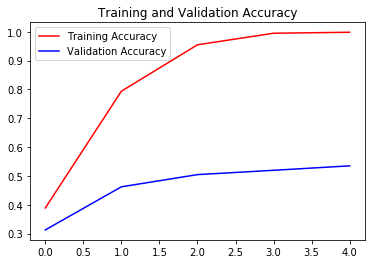

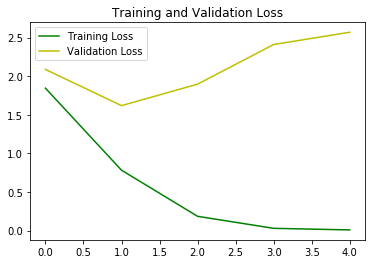

In [10]:
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
epochs = range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)

plt.figure()
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)

plt.show()